In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [57]:
# 打开.mat文件
mat_file = h5py.File('20220308130801_ECA_MONI.mat', 'r')

# 查看文件中包含的数据集
# for name in mat_file:
    # print(name)

# 获取reference
dataset = mat_file['sref']
reference = dataset[()]
reference = reference['real']+1j * reference['imag'] 
reference = reference.flatten()

# 获取surveillance 
dataset = mat_file['dbf_st']
surveillance = dataset[()]
surveillance = surveillance['real']+1j * surveillance['imag'] 
surveillance = surveillance.flatten()

In [58]:
def frequency_shift(x, fc, Fs, phase_offset=0):
    '''frequency shift x by fc where Fs is the sample rate of x'''
    nn = np.arange(x.shape[0], dtype=np.complex64)
    return x*np.exp(1j*2*np.pi*fc*nn/Fs + 1j*phase_offset)


def xcorr(s1, s2, nlead, nlag):
    ''' cross-correlate s1 and s2 with sample offsets from -1*nlag to nlead'''
    return signal.correlate(s1, np.pad(s2, (nlag, nlead), mode='constant'),
        mode='valid')

In [59]:
def direct_xambg(refChannel, srvChannel, rangeBins, freqBins, sampleRate):
    ''' Direct Cross-Ambiguity Fuction (time domain method)
    
    Args:
        refChannel: reference channel data
        srvChannel: surveillance channel data
        rangeBins:  number of range bins to compute
        freqBins:   number of doppler bins to compute
        sampleRate: input sample rate in Hz
    Returns:
        ndarray of dimensions (nf, nlag+1, 1) containing the cross-ambiguity
        surface. third dimension added for easy stacking in dask.
    '''
    
    # calculate the coherent processing interval in seconds
    CPI = refChannel.shape[0]/sampleRate

    # pre-allocate space for the result
    xambg = np.zeros((freqBins, rangeBins+1), dtype=np.complex64)

    # loop over frequency bins
    for i in range(freqBins):
        # get Doppler shift for the current bin
        df = (i - 0.5*freqBins)/CPI

        # create a frequency shifted copy of the reference signal
        ref_shifted = frequency_shift(refChannel, df, sampleRate)

        # correlate surveillance and shifted reference signals
        xambg[i,:] = xcorr(ref_shifted, srvChannel, rangeBins, 0)


    # plt.imshow(10*np.log10(np.abs(xambg)), extent=[0, rangeBins, -20, 20], aspect='auto', cmap='plasma')
    plt.imshow(np.abs(xambg), extent=[0, rangeBins, -20, 20], aspect='auto', cmap='plasma')
    plt.xlabel('Range (km)')
    plt.ylabel('Doppler (Hz)')
    plt.show()

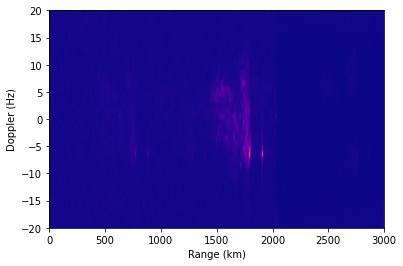

In [60]:
direct_xambg(reference, surveillance, 3000, 40, 48e6)